## Imports

In [2]:
# !pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
import os
import keras
import pickle
import pyarrow
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#set ggplot style
plt.style.use('ggplot')

warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Import Data

In [4]:
# Dynamic parameters
data_dir  = '../data/' + str(datetime.date(datetime.now()))
agg_file  = 'agg_data_{}.parquet.gzip'.format(datetime.date(datetime.now()))
trend_file  = 'trend_{}.csv'.format(datetime.date(datetime.now()))

# import data
df = pd.read_parquet(os.path.join(data_dir, agg_file))
# df = pd.read_csv(os.path.join(data_dir, trend_file), index_col=[0])

### Plotting functions

In [5]:
# Plots
def plot_scatter_2vars(tmp_df, x_col, y_col):
    tmp_df.plot(x=x_col, y=y_col, style='o')  
    plt.title('Scatter plot for correlation of ' + x_col + ' and ' + y_col)  
    plt.xlabel(x_col)  
    plt.ylabel(y_col)  
    plt.show()

def plot_scatter_1var(tmp_df, col):    
    tmp_df.groupby(['date'])[col].sum().plot(figsize=(10, 6), style='o') 
    plt.title('Regression on accumalitive Sum of Confirmed Cases')  
    plt.xlabel('date')  
    plt.ylabel('confirmed cases')  
    plt.show()

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


## Type Conversion

In [6]:
# Convert types
if 'new_confirmed_cases' in df.columns:
    for col in ['new_confirmed_cases', 'new_deaths', 'new_recoveries', 'currently_infected', 'delta']:
        df[col] = df[col].astype(float)   
else:
    for col in ['confirmed', 'deaths', 'recovered']:
        df[col] = df[col].replace('', 0).astype(float)

df['date'] = df['date'].astype('datetime64[ns]')

In [7]:
df.head()

,confirmed,country,deaths,datetime,province,recovered,date
0,1.0,Mainland China,0.0,2020-01-22 17:00:00,Anhui,0.0,2020-01-22
21,0.0,Mainland China,0.0,2020-01-22 17:00:00,Qinghai,0.0,2020-01-22
22,0.0,Mainland China,0.0,2020-01-22 17:00:00,Shaanxi,0.0,2020-01-22
23,2.0,Mainland China,0.0,2020-01-22 17:00:00,Shandong,0.0,2020-01-22
24,9.0,Mainland China,0.0,2020-01-22 17:00:00,Shanghai,0.0,2020-01-22


### Helper Functions

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Set Constants

In [10]:
# Convert types
if 'new_confirmed_cases' in df.columns:
    series = np.array(df.new_confirmed_cases)
    time = np.array(df.index)
else:
    series = np.array(df.confirmed)
    df = df.reset_index()
    time = np.array(df.index)


In [11]:
# time

In [12]:
split_time = 800
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 100


### Inspect Data

In [13]:
#Calculate range of trend data
def time_range(tmp_df):
    print('...', tmp_df['date'].min().date(), 'to',  tmp_df['date'].max().date())
    print('...', tmp_df['date'].min() - tmp_df['date'].max())
    print('\n')

print('Calulcating date ranges...\n')
time_range(df)

Calulcating date ranges...

... 2020-01-22 to 2020-02-23
... -32 days +00:00:00




In [14]:
df.head(2)

,index,confirmed,country,deaths,datetime,province,recovered,date
0,0,1.0,Mainland China,0.0,2020-01-22 17:00:00,Anhui,0.0,2020-01-22
1,21,0.0,Mainland China,0.0,2020-01-22 17:00:00,Qinghai,0.0,2020-01-22


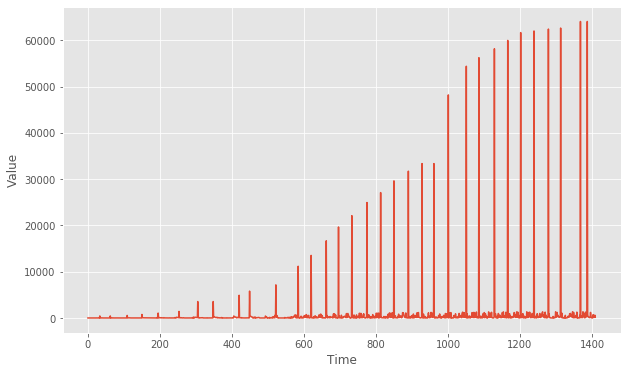

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [16]:
# time_train, x_train

In [17]:
time_valid, x_valid

(array([ 800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,
         811,  812,  813,  814,  815,  816,  817,  818,  819,  820,  821,
         822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,
         833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,
         844,  845,  846,  847,  848,  849,  850,  851,  852,  853,  854,
         855,  856,  857,  858,  859,  860,  861,  862,  863,  864,  865,
         866,  867,  868,  869,  870,  871,  872,  873,  874,  875,  876,
         877,  878,  879,  880,  881,  882,  883,  884,  885,  886,  887,
         888,  889,  890,  891,  892,  893,  894,  895,  896,  897,  898,
         899,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
         910,  911,  912,  913,  914,  915,  916,  917,  918,  919,  920,
         921,  922,  923,  924,  925,  926,  927,  928,  929,  930,  931,
         932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,
         943,  944,  945,  946,  947, 

## Find Optimal Learning Rate

In [ ]:
'''
Train a model using LearningRateScheduler to find the be 
learning rate
'''
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"], verbose=2)
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
Epoch 1/150
3/3 [==============================] - 4s 1s/step - loss: 248.7675 - mae: 243.8102
Epoch 2/150
3/3 [==============================] - 1s 186ms/step - loss: 149.4929 - mae: 243.7983
Epoch 3/150
3/3 [==============================] - 1s 188ms/step - loss: 148.7446 - mae: 243.7760
Epoch 4/150
3/3 [==============================] - 1s 194ms/step - loss: 150.5043 - mae: 243.7439
Epoch 5/150
3/3 [==============================] - 1s 186ms/step - loss: 148.1928 - mae: 243.6972
Epoch 6/150
3/3 [==============================] - 1s 186ms/step - loss: 148.8685 - mae: 243.6242
Epoch 7/150
3/3 [==============================] - 1s 186ms/step - loss: 147.8625 - mae: 243.5456
Epoch 8/150
3/3 [==============================] - 1s 188ms/step - loss: 146.8842 - mae: 243.4819
Epoch 9/150
3/3 [==============================] - 1s 186ms/step - loss: 149.5950 - mae: 243.4167
Epoch 10/150
3/3 [==

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 2000])

## Retrain model with Optimal LR

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=30, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.2)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

## Forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
print(rnn_forecast)